In [202]:
dataframe = pd.read_csv('DSCancerDeMamaSinDatosPerdidos.csv', sep=';')
clasificadores = ['Benigno', 'Maligno']
dataframe.head(10)

,BIRADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,57,1,5,3,1
4,5,76,1,4,3,1
5,3,42,2,1,3,1
6,4,36,3,1,2,0
7,4,60,2,1,2,0
8,4,54,1,1,3,0
9,3,52,3,4,3,0


In [204]:
dataframe.describe()

,BIRADS,Age,Shape,Margin,Density,Severity
count,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000
mean,4.314634,55.739024,2.775610,2.808537,2.915854,0.481707
std,0.669248,14.684062,1.243647,1.569295,0.351508,0.499970
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.750000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,5.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [206]:
dataframe.groupby('Severity').size()

Severity
0    425
1    395
dtype: int64

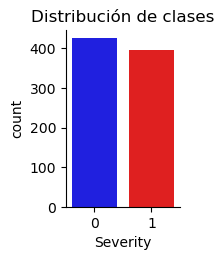

In [208]:
# Mostrar gráfico de barras
import seaborn as sb

#Aseguramos que los números son enteros
dataframe['Severity'] = dataframe['Severity'].astype(int)
sb.catplot(x='Severity', hue='Severity', data= dataframe, kind="count", height=2.5, aspect=0.8, palette={0:"blue",1:"red"}, legend=False)
plt.title("Distribución de clases")
plt.show()

In [210]:
x = dataframe.drop('Severity', axis=1)
y = dataframe['Severity']

In [212]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

In [214]:
from sklearn.neighbors import KNeighborsClassifier
knn_mm = KNeighborsClassifier(n_neighbors=3)
knn_mm.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [216]:
predicciones = knn_mm.predict(x_test)

         Benigno  Maligno
Benigno      105       14
Maligno       26      101
              precision    recall  f1-score   support

     Benigno       0.80      0.88      0.84       119
     Maligno       0.88      0.80      0.83       127

    accuracy                           0.84       246
   macro avg       0.84      0.84      0.84       246
weighted avg       0.84      0.84      0.84       246



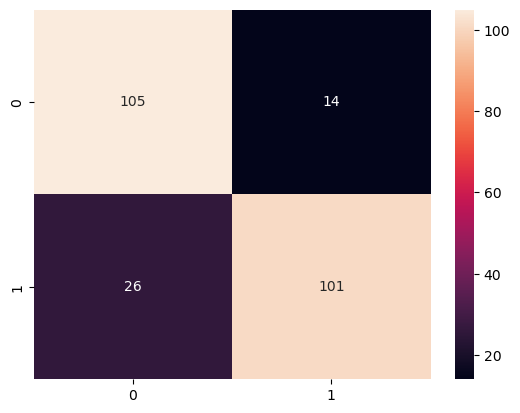

In [218]:
from sklearn.metrics import classification_report, confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test,predicciones).ravel()

sns.heatmap(confusion_matrix(y_test,predicciones), annot=True, fmt="d")
            
labels = ["Benigno","Maligno"]
matriz = confusion_matrix(y_test,predicciones, labels=[0,1])
print(pd.DataFrame(matriz, index = labels, columns = labels))

print(classification_report(y_test,predicciones,target_names=clasificadores))
#Columnas lo que dice el sistema, filas lo que dice la realidad

In [220]:
sample = pd.DataFrame([[4, 65, 3, 5, 3]], columns=x.columns)
print("\nEjemplo de predicción:")
print(f"Predicción: {clasificadores[knn_mm.predict(sample)[0]]}")
print(f"Probabilidades: {knn_mm.predict_proba(sample)}")


Ejemplo de predicción:
Predicción: Benigno
Probabilidades: [[0.66666667 0.33333333]]


In [222]:
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_mm, f)

In [224]:
from flask import Flask, jsonify, request
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        req_json = request.get_json()
        print("Datos recibidos en la API:", req_json)  
        input_data = pd.DataFrame(req_json)
        print("DataFrame creado:", input_data.to_dict())  
    except Exception as e:
        print("Error al procesar JSON:", str(e))  
        return jsonify({'error': str(e)}), 400

    if input_data.empty:
        print("Error: DataFrame vacío")  
        return jsonify({'error': 'No data provided'}), 400

    expected_columns = ['BIRADS', 'Age', 'Shape', 'Margin', 'Density']
    if not all(col in input_data.columns for col in expected_columns):
        print("Error: Columnas faltantes", input_data.columns.tolist())  
        return jsonify({'error': 'Missing required columns'}), 400

    try:
        with open('knn_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
        print("Modelo cargado correctamente")  
    except Exception as e:
        print("Error al cargar el modelo:", str(e))  
        return jsonify({'error': 'Failed to load model'}), 500

    try:
        predictions = loaded_model.predict(input_data[expected_columns])
        predictions = [clasificadores[pred] for pred in predictions] 
        probabilities = loaded_model.predict_proba(input_data[expected_columns]).tolist()
        print("Predicciones realizadas:", predictions)  
    except Exception as e:
        print("Error al hacer predicciones:", str(e)) 
        return jsonify({'error': 'Prediction failed'}), 500

    response = jsonify({
        'predictions': predictions,
        'probabilities': probabilities
    })
    response.status_code = 200
    print("Respuesta enviada:", response.get_json())  
    return response

def run_flask():
    app.run(port=8001, use_reloader=False)

Thread(target=run_flask).start()

time.sleep(3) 

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8001
Press CTRL+C to quit


In [226]:
test_data = pd.DataFrame({
    'BIRADS': [4, 5],
    'Age': [65, 70],
    'Shape': [3, 4],
    'Margin': [5, 5],
    'Density': [3, 3]
})

data_json = test_data.to_json(orient='records')

print("Datos enviados en el POST:")
print(data_json)

headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

try:
    print("Enviando solicitud POST a http://localhost:8001/predict")  # Depuración
    response = requests.post('http://localhost:8001/predict', data=data_json, headers=headers)
    print('\nConsulta a la API:')
    print('Status:', response.status_code)
    print('Respuesta:', response.json())
except Exception as e:
    print(f"Error al consultar la API: {e}")

Datos enviados en el POST:
[{"BIRADS":4,"Age":65,"Shape":3,"Margin":5,"Density":3},{"BIRADS":5,"Age":70,"Shape":4,"Margin":5,"Density":3}]
Enviando solicitud POST a http://localhost:8001/predict


127.0.0.1 - - [04/May/2025 21:51:36] "POST /predict HTTP/1.1" 200 -


Datos recibidos en la API: [{'BIRADS': 4, 'Age': 65, 'Shape': 3, 'Margin': 5, 'Density': 3}, {'BIRADS': 5, 'Age': 70, 'Shape': 4, 'Margin': 5, 'Density': 3}]
DataFrame creado: {'BIRADS': {0: 4, 1: 5}, 'Age': {0: 65, 1: 70}, 'Shape': {0: 3, 1: 4}, 'Margin': {0: 5, 1: 5}, 'Density': {0: 3, 1: 3}}
Modelo cargado correctamente
Predicciones realizadas: ['Benigno', 'Maligno']
Respuesta enviada: {'predictions': ['Benigno', 'Maligno'], 'probabilities': [[0.6666666666666666, 0.3333333333333333], [0.3333333333333333, 0.6666666666666666]]}

Consulta a la API:
Status: 200
Respuesta: {'predictions': ['Benigno', 'Maligno'], 'probabilities': [[0.6666666666666666, 0.3333333333333333], [0.3333333333333333, 0.6666666666666666]]}
